In [2]:
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba.typed import List
import time
from numba.typed import Dict
from numba.core import types
import numba

In [6]:
@jit(nopython=True)
def initialize_graph(n_list,groups, mm:int,aa:int,bb:int):
    """
    Create inital graph with only mm connectionss

    :params:

    :X_woe: WOE transformed dataset

    :y: target variable

    :return: 

    :rfe_df: RFE ranking of features 

    :names: names of the variables which should be dropped
    """
    for ii in np.arange(mm):
        for jj in (np.arange(aa)):
            print(ii)
            n_list.append(ii)
            
    groups.append(n_list.copy())
    return n_list, groups

In [7]:
@jit(nopython=True)
def proportional_attach(node_list,groups,group_dict, mm,aa,bb,p,indexes, iterator, num_of_nodes, group_counter):

    #initial length of an node_list, lets us get proportial attachment on the basis of the old list for each of the new added nodes
    length_init=len(node_list)
        #until you reach number of nodes which should be added
        
    #decide whether we want to append this point to existing group or create new group
    if np.random.random()>p:
        #create connections inside the group
        group_counter+=1
        new_group=List.empty_list(types.int32)
        for node in np.arange(num_of_nodes):
            indexes=List()
            #number of added node
            added_node=mm+node+iterator

            group_dict[added_node]=group_counter

            #select nodes to connect globally
            for ii in np.arange(0,bb):

                ind=np.random.randint(0,length_init)
                indexes.append(ind)

            #append selected connections to the list 
            for indx in indexes:
                node_list.append(node_list[indx])
                group=group_dict[node_list[indx]]
                val=node_list[indx]
                groups[group].append(val)
            for indx in indexes:
                node_list.append(added_node)
                new_group.append(added_node)
            
        groups.append(new_group)
        
        #create connections inside group
        init_group_length=len(groups[group_counter])
        for node in np.arange(num_of_nodes):
            indexes=List()
            added_node=mm+node+iterator
            for ii in np.arange(0,aa):

                ind=np.random.randint(0,init_group_length)
                indexes.append(ind)
            #append selected connections to the list 
            for indx in indexes:
                val=groups[group_counter][indx]
                node_list.append(val)
                groups[group_counter].append(val)
            for indx in indexes:
                val=added_node
                groups[group_counter].append(val)
                node_list.append(added_node)
    else:
            #needs checking
            for node in np.arange(num_of_nodes):
                indexes=List()
                #number of added node
                added_node=mm+node+iterator
                #initial node to which our new node will attach and connect to this group
                initial_index=np.random.randint(0,length_init)

                #attach this new node to this group
                group_number=group_dict[node_list[initial_index]]
                group_dict[added_node]=group_number
                
                for ii in np.arange(0,aa-1):
                    ind=np.random.randint(0,len(groups[group_number]))
                    indexes.append(ind)
                #append selected connections to the list 
                #append initial connection to the list
                node_list.append(node_list[initial_index])
                groups[group_number].append(node_list[initial_index])
                for indx in indexes:
                    val=groups[group_number][indx]
                    node_list.append(val)
                    groups[group_number].append(val)
                for indx in indexes:
                    val=added_node
                    groups[group_number].append(val)
                    node_list.append(added_node)
                    
                indexes=List()
                #select nodes to connect globally
                
                for ii in np.arange(0,bb):
                    ind=np.random.randint(0,length_init)
                    indexes.append(ind)

                #append selected connections to the list 
                for indx in indexes:
                    node_list.append(node_list[indx])
                    group=group_dict[node_list[indx]]
                    val=node_list[indx]
                    groups[group].append(val)
                for indx in indexes:
                    node_list.append(added_node)
                    groups[group_number].append(added_node)
                    

    
    return group_counter


In [8]:
m=2
initial_nodes=m
# n_nodes=10**8
n_nodes=10**6
group_dict = Dict.empty(
    key_type=types.int64,
    value_type=types.int64,
)
for ii in np.arange(initial_nodes):
    group_dict[ii]=0
# a=m-1
a=2
b=2
# node_list=np.full((m-1)*m+n_nodes*(a+b)*2,-1, dtype= np.int32)
node_list=List.empty_list(types.int32)
list_size=len(node_list)
groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))
node_list,groups=initialize_graph(node_list,groups, 2,a,b)


<ipython-input-6-b1582a7b2f65>:21: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  n_list.append(ii)


0
0
1
1


In [9]:
ii=0
num_of_nodes=2*a+1
indexes=np.full(a+b,-1)
group_counter=0
p=1
for n_number in tqdm(np.arange(m,n_nodes+m,num_of_nodes)):
    group_counter=proportional_attach(node_list,groups,group_dict,m,a,b,p,indexes,ii,num_of_nodes, group_counter)
    ii+=num_of_nodes

100%|██████████| 200000/200000 [00:07<00:00, 28520.90it/s]


Text(0.5, 1.0, 'Wykres dla m=2')

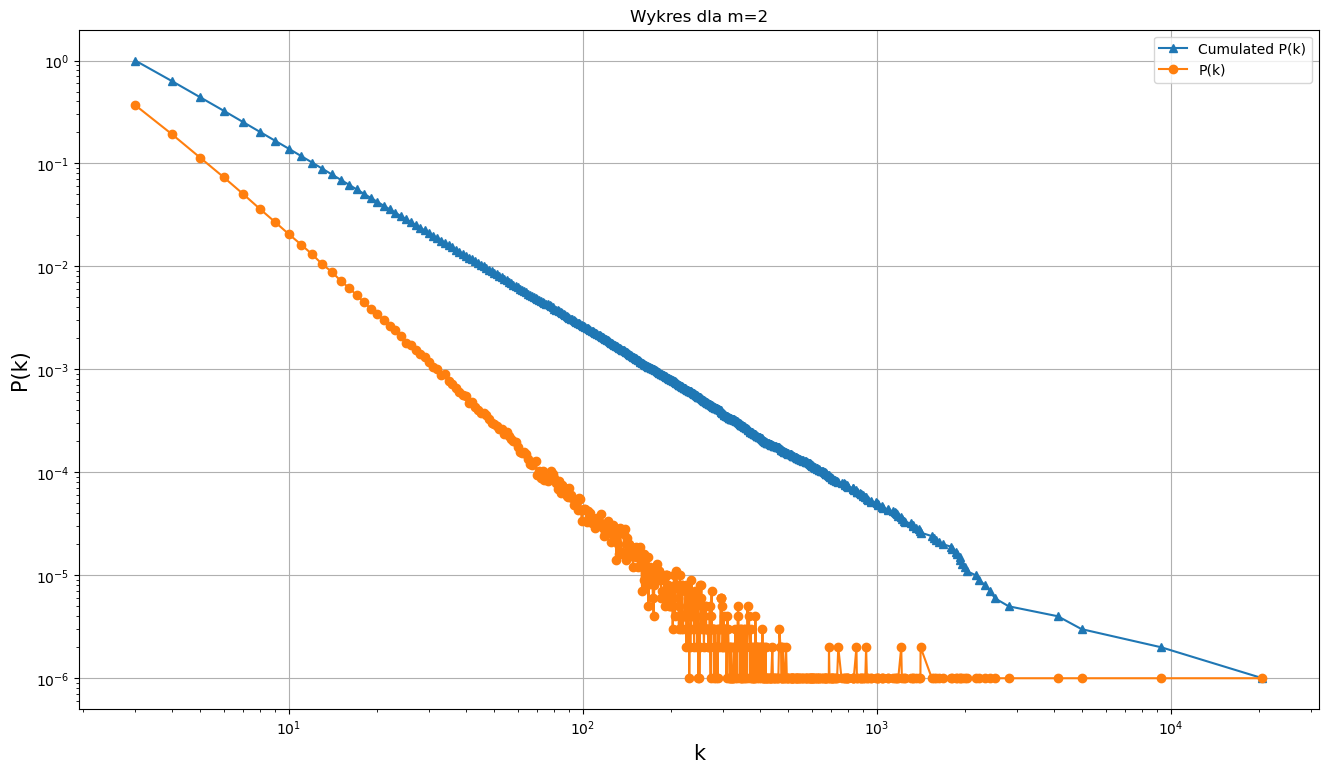

In [10]:
vals,counts=np.unique(node_list,return_counts=True)
vals,counts=np.unique(counts,return_counts=True)
prob=counts/np.sum(counts)
plt.figure(figsize=(16,9),dpi= 100)
plt.loglog(vals,np.cumsum(prob[::-1])[::-1],"^-",label="Cumulated P(k)")
plt.loglog(vals,prob,"o-",label="P(k)")
plt.legend()
plt.grid()
plt.xlabel("k",fontsize=15)
plt.ylabel("P(k)",fontsize=15)
plt.title(f"Wykres dla m={m}")